## Import libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import itertools

from skimage.io import imread, imshow
from skimage import data

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [46]:
## get current directory
print(os. getcwd())
torch.__version__

/projectnb2/dl523/projects/COVIDCT2/Ziwei/scripts


'1.11.0+cu102'

## Setting

In [47]:
DPATH = "/projectnb2/dl523/projects/COVIDCT2/dataset/IDC"
label_map = {"no IDC": 0, "IDC": 1}

## Load the data

In [48]:
X = np.load(os.path.join(DPATH,"X.npy"))
print(X.shape)
Y = np.load(os.path.join(DPATH,"Y.npy"))
print(Y.dtype)
print(Y.shape)

(5547, 50, 50, 3)
int64
(5547,)


In [49]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


## Define a BreastCancer Dataset Class

In [50]:
class BreastCancer(Dataset):
    def __init__(self, DPATH, X_file, Y_file, transform=None, target_transform=None):
        self.X = np.load(os.path.join(DPATH,X_file))
        self.Y = np.load(os.path.join(DPATH,Y_file))
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,index):
        ## get image & label
        image, label = self.X[index], self.Y[index]
        
        ## transform 
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
            
        return image, label

## Double check what transforms should be used

float64
False
tensor([[[0.0000, 0.0000, 0.9255,  ..., 0.3765, 0.0000, 0.0000],
         [0.9216, 0.0000, 0.0000,  ..., 0.0000, 0.9137, 0.0000],
         [0.0000, 0.2471, 0.0000,  ..., 0.0000, 0.0000, 0.2471],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2471, 0.0000, 0.1255],
         [0.0000, 0.0000, 0.9255,  ..., 0.8784, 0.0000, 0.0000],
         [0.9216, 0.0000, 0.0000,  ..., 0.0000, 0.9294, 0.0000]],

        [[0.0000, 0.0000, 0.2471,  ..., 0.9137, 0.0000, 0.0000],
         [0.2471, 0.0000, 0.3765,  ..., 0.0000, 0.2471, 0.0000],
         [0.7529, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.9255, 0.0000,  ..., 0.0000, 0.0000, 0.8824],
         [0.0000, 0.0000, 0.2471,  ..., 0.9020, 0.0000, 0.0000],
         [0.2471, 0.0000, 0.8784,  ..., 0.0000, 0.2471, 0.0000]],

        [[0.0000, 0.2510, 0.0000,  ..., 0.2471, 0.0000, 0.8784],
         [0.0000, 0.0000, 0.8863,  ..., 0.7529, 0.0000, 0.0000],
         [0.8471, 0.0000, 0.0000,  ..., 0.00

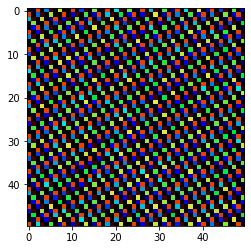

tensor(0.2013)


In [65]:
X_1 = X[0]/256
#print(X_1)
print(X_1.dtype)
print(np.issubdtype(X_1.dtype,np.uint8))

X_transforms = transforms.Compose([
        transforms.ToPILImage(mode='RGB'),
        transforms.ToTensor()])

X_1 = X_transforms(X_1)
#X_1 = transforms.ToPILImage(X_1)
#X_1 = transforms.ToTensor(X_1)
print(X_1)
print(type(X_1))
print(X_1.shape)
print(X_1.ndim)
plt.imshow(X_1.permute(1,2,0))
plt.show()

print(X_1[0].mean())



In [53]:
train_transformer = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop((32,32), scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.8279,0.5822,0.7566),(0.1137,0.1326,0.0875))
])

val_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.8279,0.5822,0.7566),(0.1137,0.1326,0.0875))
])

In [35]:
X_file = "X.npy"
Y_file = "Y.npy"
BreastCancerDataSet = BreastCancer(DPATH, X_file, Y_file, 
                                   transform=train_transformer,
                                   target_transform=None)

BC_dataloader = DataLoader(BreastCancerDataSet, batch_size=64, shuffle=True, num_workers=1)

In [36]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


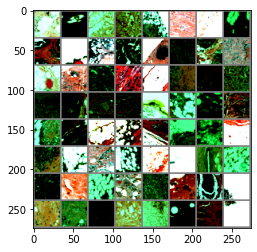

In [37]:
## look at a batch
data_iter = iter(BC_dataloader)
images, labels = data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))